In [1]:
! pip install -q kaggle
! pip install datasets
! pip install -U accelerate
! pip install -U transformers[torch]
from datasets import Dataset, DatasetDict
import numpy as np
import pandas as pd
!pip install evaluate
import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_

In [2]:
from datasets import load_dataset

dataset = load_dataset("zeroshot/twitter-financial-news-topic")
dataset

Generating train split:   0%|          | 0/16990 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4117 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16990
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4117
    })
})

In [3]:
np.unique(dataset["train"]['label'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

We have 15 different classes.

In [4]:
print(pd.DataFrame(dataset["train"]).groupby('label').size())

label
0      255
1      837
2     3545
3      321
4      359
5      987
6      524
7      624
8      166
9     1557
10      69
11      44
12     487
13     471
14    1822
15     501
16     985
17     495
18    2118
19     823
dtype: int64


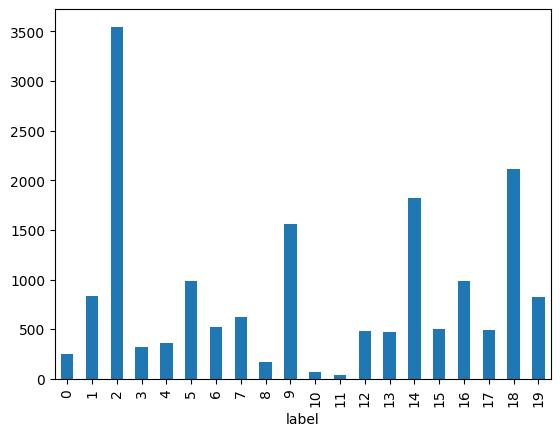

In [5]:
hist = pd.DataFrame(dataset["train"]).groupby('label').size().plot(kind='bar')

We notice that the classes are unbalanced.

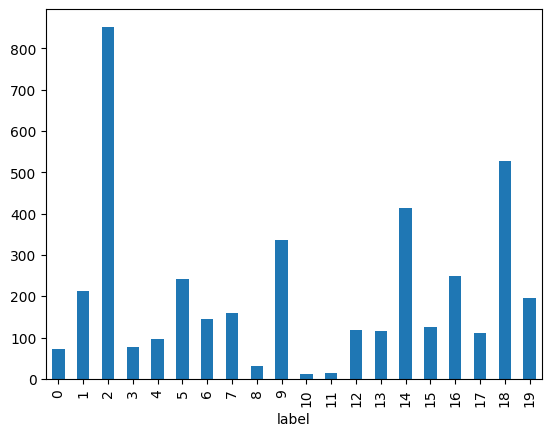

In [6]:
hist = pd.DataFrame(dataset["validation"]).groupby('label').size().plot(kind='bar')

The split seems to have been stratified to keep the classes distribution constant between train and validation. Let's map the labels with their description:

In [7]:
#mapping of labels vs sentiment
id2label = {
    0: "Analyst Update",
    1: "Fed | Central Banks",
    2: "Company | Product News",
    3: "Treasuries | Corporate Debt",
    4: "Dividend",
    5: "Earnings",
    6: "Energy | Oil",
    7: "Financials",
    8: "Currencies",
    9: "General News | Opinion",
    10: "Gold | Metals | Materials",
    11: "IPO",
    12: "Legal | Regulation",
    13: "M&A | Investments",
    14: "Macro",
    15: "Markets",
    16: "Politics",
    17: "Personnel Change",
    18: "Stock Commentary",
    19: "Stock Movement",
}

Ley's look at the tweets' texts:

In [8]:
dataset["train"]['text'][:30]

["Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh",
 'Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says  https://t.co/fLS2w57iCz',
 'Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition  https://t.co/1EmtywmYpr',
 "Analysts react to Tesla's latest earnings, break down what's next for electric car maker  https://t.co/kwhoE6W06u",
 'Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside  https://t.co/jPpdl0D9s4',
 'Barclays believes earnings for these underperforming stocks may surprise Wall Street  https://t.co/PHbsyVGAyE',
 'Bernstein upgrades Alibaba, says shares can rally more than 20% from here  https://t.co/m3ApoPRGU0',
 "Analysts react to Netflix's strong quarter, with some pointing to a potential bottom for the stock  https://t.co/cQngJsyefD",
 'Buy Chevron as shares look attractive at these levels, HSBC says 

Load the model (we take a classical bert)

In [9]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"

Tokenize the dataset

In [10]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_tweets = dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16990 [00:00<?, ? examples/s]

Map:   0%|          | 0/4117 [00:00<?, ? examples/s]

Dynamically pad the tweets

In [11]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

##Train the model

Take basic training arguments to test the model

In [12]:
from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir="twitter_classification_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_token='',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Instantiate the model

In [13]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=20)

from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_tweets["train"],
    eval_dataset=tokenized_tweets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.616300,0.468048
2,0.285800,0.372466
3,0.151300,0.397495
4,0.088200,0.460122
5,0.044600,0.533955
6,0.026300,0.534200
7,0.022400,0.523804
8,0.016600,0.559408
9,0.013600,0.568618
10,0.005800,0.572301


TrainOutput(global_step=10620, training_loss=0.16441167259059158, metrics={'train_runtime': 1494.2169, 'train_samples_per_second': 113.705, 'train_steps_per_second': 7.107, 'total_flos': 6443733730009488.0, 'train_loss': 0.16441167259059158, 'epoch': 10.0})

Plot the training and validation loss

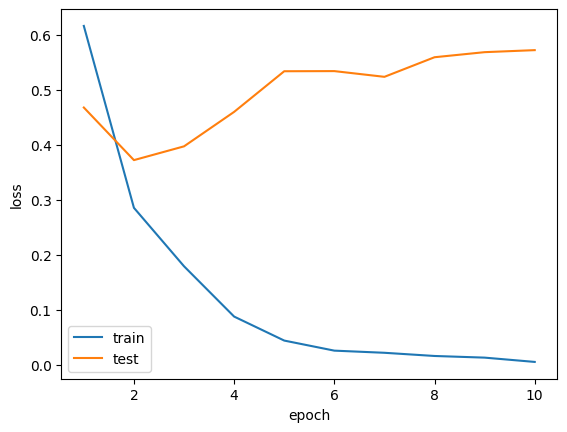

In [51]:
import matplotlib.pyplot as plt

train_loss = [trainer.state.log_history[1]['loss'],
              trainer.state.log_history[4]['loss'],
              trainer.state.log_history[6]['loss'],
              trainer.state.log_history[10]['loss'],
              trainer.state.log_history[13]['loss'],
              trainer.state.log_history[16]['loss'],
              trainer.state.log_history[19]['loss'],
              trainer.state.log_history[22]['loss'],
              trainer.state.log_history[26]['loss'],
              trainer.state.log_history[29]['loss']]
test_loss = [trainer.state.log_history[2]['eval_loss'],
              trainer.state.log_history[5]['eval_loss'],
              trainer.state.log_history[8]['eval_loss'],
              trainer.state.log_history[11]['eval_loss'],
              trainer.state.log_history[14]['eval_loss'],
              trainer.state.log_history[17]['eval_loss'],
              trainer.state.log_history[20]['eval_loss'],
              trainer.state.log_history[23]['eval_loss'],
              trainer.state.log_history[27]['eval_loss'],
              trainer.state.log_history[30]['eval_loss']]
loss = [train_loss,test_loss]
x = np.arange(1,11,1)

plt.plot(x,loss[0],x,loss[1])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train','test'])
plt.show()

Clear pattern of overfitting. We should stick with a less trained model.

##Larger model

We're trying the large BERT

In [53]:
checkpoint = "bert-large-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=20)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
tokenized_tweets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/16990 [00:00<?, ? examples/s]

Map:   0%|          | 0/4117 [00:00<?, ? examples/s]

In [55]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

We train over only 3 epochs as we saw more epochs overfitted the smaller model

In [56]:
training_args = TrainingArguments(
    output_dir="twitter_classification_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_token='',
)


trainer_large = Trainer(
    model,
    training_args,
    train_dataset=tokenized_tweets["train"],
    eval_dataset=tokenized_tweets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer_large.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.493800,0.373235
2,0.212000,0.365291
3,0.088300,0.389755


TrainOutput(global_step=3186, training_loss=0.36238912449493693, metrics={'train_runtime': 1497.7017, 'train_samples_per_second': 34.032, 'train_steps_per_second': 2.127, 'total_flos': 6846981209373120.0, 'train_loss': 0.36238912449493693, 'epoch': 3.0})

Similar performance to the smaller model.

## Model pretrained on domain-specific knowledge

In [58]:
checkpoint = "nickmuchi/deberta-v3-base-finetuned-finance-text-classification"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=20, ignore_mismatched_sizes=True)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at nickmuchi/deberta-v3-base-finetuned-finance-text-classification and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
tokenized_tweets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/16990 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/4117 [00:00<?, ? examples/s]

In [60]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [61]:
training_args = TrainingArguments(
    output_dir="twitter_classification_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_token='',
)


trainer_large = Trainer(
    model,
    training_args,
    train_dataset=tokenized_tweets["train"],
    eval_dataset=tokenized_tweets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer_large.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.584900,0.417853
2,0.272200,0.341140
3,0.146800,0.331031


TrainOutput(global_step=3186, training_loss=0.4757625229015937, metrics={'train_runtime': 700.7967, 'train_samples_per_second': 72.732, 'train_steps_per_second': 4.546, 'total_flos': 1893072380827488.0, 'train_loss': 0.4757625229015937, 'epoch': 3.0})

The domain-specific knowledge (learnt on another classification taks) doesn't improve the performance at first but the model seems to imrove a bit after two more epochs.